In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, sys
from netCDF4 import Dataset as open_ncfile
sys.path.append("/home/ysilvy/Density_bining/Yona_analysis/programs/")
from lib_remapping import remaptoz
from maps_matplot_lib import defVarmme, zon_2Dz, custom_div_cmap
from scipy.interpolate import griddata
import datetime
import pickle

In [2]:
indir_histrcp = '/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/'
file_histrcp = glob.glob(indir_histrcp+'*'+'IPSL-CM5A-LR'+'*r2i1p1*zon2D.nc')[0]
fhrcp = open_ncfile(file_histrcp,'r')

model = {'name':'IPSL-CM5A-LR'  ,'props':[6,3,11,156], 'picontrol':[1000],'correctFile':[0,0,0],
          'file_end_hist':'v20111119', 'file_end_histNat':'v20120430',
          'hist-rcp85':['r2i1p1','r3i1p1','r4i1p1']}
tstart = model['props'][2]
tend = model['props'][3]

lat = fhrcp.variables['latitude'][:]
density = fhrcp.variables['lev'][:]
depth = fhrcp.variables['isondepth'][tstart:tend+95,:,:,:]

In [3]:
file_histrcp

'/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/cmip5.IPSL-CM5A-LR.historical-rcp85.r2i1p1.an.ocn.Omon.density.ver-v20111119_zon2D.nc'

In [15]:
# Choose remapping method
#remap = 'IPSL_r2i1p1_isondepth'
remap = 'EN4_volume_refill'

In [4]:
if remap == 'IPSL_r2i1p1_isondepth':
    # Average depth of isopycnals over whole time series
    ztorho = np.ma.average(depth,axis=0)
else:
    # Or read remapping relationship constructed from EN4 climatology
    ztorho = pickle.load( open( "/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/EN4.pseudo_depth.zonal.pkl", "rb" ) )

In [5]:
# Read ToE fields
indirz = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal_z/toe_rcp85_histNat/'
indirr = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal/toe_rcp85_histNat/'

varname = defVarmme('salinity'); v = 'S'
#varname = defVarmme('temp'); v = 'T'
var = varname['var_zonal_w/bowl']
legVar = varname['legVar']
unit = varname['unit']
minmax = varname['minmax_zonal_rcp85']
multstd = 2 

if v=='S':
    varName = 'salinity'
else:
    varName = 'temperature'

In [6]:
# In pressure
filez = 'cmip5.IPSL-CM5A-LR.r2i1p1.'+legVar+'_toe_zonal_rcp_histNat.nc'
fz = open_ncfile(indirz+filez,'r')
toez = fz.variables[varName+'ToE2_z'][:,:,:] + 1860
targetz = fz.variables['depth'][:].data
model_name = filez.split('.')[1]
run = filez.split('.')[2]

In [7]:
# In density
if v == 'S':
    filerho = 'cmip5.IPSL-CM5A-LR.toe_zonal_rcp_histNat.nc'
else:
    filerho = 'cmip5.IPSL-CM5A-LR.Temperature_toe_zonal_rcp_histNat.nc'
frho = open_ncfile(indirr+filerho,'r')
toerho = frho.variables[var+'ToE2'][2,:,:,:] + 1860 # index 2 (3rd position) corresponds to run r2i1p1 (ls -U order)
var_change = frho.variables[var+'_change'][2,:,:,:]
toerho.fill_value = 1.e20
if v=='S':
    idx = np.argwhere(var_change.mask==True)
    toerho[idx[:,0],idx[:,1],idx[:,2]] = np.ma.masked

In [8]:
# Remap toerho to z
toerhotoz = remaptoz(toerho,ztorho,targetz)

/home/ysilvy/.conda/envs/mypython3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/ysilvy/.conda/envs/mypython3/lib/python3.6/site-packages/numpy/ma/core.py:1181: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)


In [9]:
toerhotoz.shape, ztorho.shape
targetz

array([4.9999380e+00, 1.5000288e+01, 2.5001759e+01, 3.5005413e+01,
       4.5013317e+01, 5.5029499e+01, 6.5061806e+01, 7.5125511e+01,
       8.5250366e+01, 9.5494286e+01, 1.0596992e+02, 1.1689624e+02,
       1.2869791e+02, 1.4219525e+02, 1.5896062e+02, 1.8196278e+02,
       2.1664792e+02, 2.7247672e+02, 3.6430304e+02, 5.1153476e+02,
       7.3220087e+02, 1.0332173e+03, 1.4056975e+03, 1.8308850e+03,
       2.2897678e+03, 2.7682424e+03, 3.2574788e+03, 3.7524421e+03,
       4.2504014e+03, 4.7499131e+03, 5.2502266e+03], dtype=float32)

In [10]:
# Plot remapped ToE from rho to z

# -- Make variable bundles for each basin
varAtlrhoz = {'name': 'Atlantic', 'var_change': toerhotoz[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}
varPacrhoz = {'name': 'Pacific', 'var_change': toerhotoz[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}
varIndrhoz = {'name': 'Indian', 'var_change': toerhotoz[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}

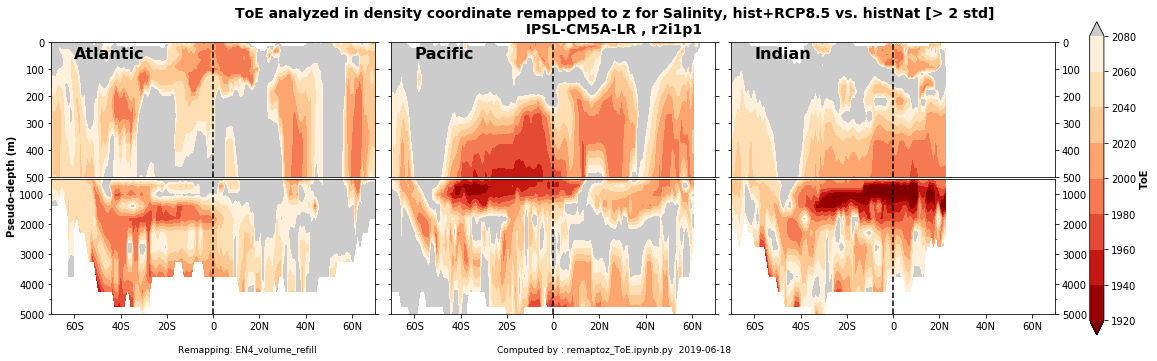

In [16]:
# -- Create figure and axes instances
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

deltat=20
minyear=1920
domzed = [0,500,5000]
# -- Color map
cmap = 'OrRd_r'
# -- Unit
unit = 'ToE'
# -- Levels
minmax = [minyear, 2080.01, deltat]
levels = np.arange(minmax[0], minmax[1], minmax[2])
ext_cmap = 'both'
# -- Put everything into a dictionary
contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':False}

# -- Contourf
# Atlantic
cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtlrhoz,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# -- Add colorbar
cb = fig.colorbar(cnplot[1], ax=axes.ravel().tolist(), ticks=levels, fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s' % (unit,), fontweight='bold')

# Pacific
cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPacrhoz,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# Indian
cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varIndrhoz,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

plt.subplots_adjust(hspace=.01, wspace=0.05, left=0.04, right=0.86)


# -- Add title
plotTitle = 'ToE analyzed in density coordinate remapped to z for ' + legVar + ', hist+RCP8.5 vs. histNat [> ' + str(multstd) + ' std]' \
    '\n %s , %s '%(model_name,run)

plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

plt.figtext(.5,.02,'Computed by : remaptoz_ToE.ipynb  '+date,fontsize=9,ha='center')
plt.figtext(.2,.02,'Remapping: '+remap,fontsize=9,ha='center')
plt.figtext(.004,.6,'Pseudo-depth (m)',rotation='vertical',fontweight='bold')

figureDir = 'models/ToE_z_analysis/'
plotName = 'toe'+v+'_gammatoz_IPSL_r2i1p1_rcp85vshistNat'
#plt.savefig('/home/ysilvy/figures/'+figureDir+plotName+'.pdf', bbox_inches='tight')

In [17]:
# Plot diff ToEz - ToErhotoz

toediff = toez - toerhotoz

# -- Make variable bundles for each basin
varAtldiff = {'name': 'Atlantic', 'var_change': toediff[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}
varPacdiff = {'name': 'Pacific', 'var_change': toediff[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}
varInddiff = {'name': 'Indian', 'var_change': toediff[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}

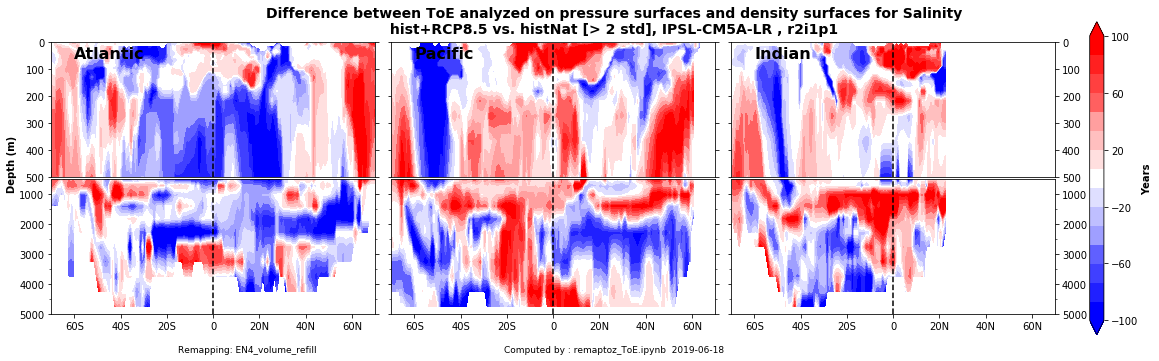

In [18]:
# -- Create figure and axes instances
fig2, axes2 = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

domzed = [0,500,5000]
# -- Color map
cmap = custom_div_cmap()
# -- Unit
unit = 'Years'
# -- Levels
minmax = [-100,100, 16]
levels = np.linspace(minmax[0], minmax[1], minmax[2])
ext_cmap = 'both'
# -- Put everything into a dictionary
contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':False}

# -- Contourf
# Atlantic
cnplot2 = zon_2Dz(plt, axes2[0,0], axes2[1,0], 'left', lat, targetz, varAtldiff,
                  contourDict, domzed, None, None)

# -- Add colorbar
cb2 = fig2.colorbar(cnplot2[1], ax=axes2.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb2.set_label('%s' % (unit,), fontweight='bold')

# Pacific
cnplot2 = zon_2Dz(plt, axes2[0,1], axes2[1,1], 'mid', lat, targetz, varPacdiff,
                  contourDict, domzed, None, None)

# Indian
cnplot2 = zon_2Dz(plt, axes2[0,2], axes2[1,2], 'right', lat, targetz, varInddiff,
                  contourDict, domzed, None, None)

plt.subplots_adjust(hspace=.01, wspace=0.05, left=0.04, right=0.86)


# -- Add title
plotTitle = 'Difference between ToE analyzed on pressure surfaces and density surfaces for ' + legVar + '\n hist+RCP8.5 vs. histNat [> ' + str(multstd) + ' std], ' \
    '%s , %s '%(model_name,run)

plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

plt.figtext(.5,.02,'Computed by : remaptoz_ToE.ipynb  '+date,fontsize=9,ha='center')
plt.figtext(.004,.6,'Depth (m)',rotation='vertical',fontweight='bold')
plt.figtext(.2,.02,'Remapping: '+remap,fontsize=9,ha='center')

figureDir = 'models/ToE_z_analysis/'
plotName = 'ToEdiffz_'+v+'_zvsgamma_IPSL_r2i1p1_rcp85vshistNat'
#plt.savefig('/home/ysilvy/figures/'+figureDir+plotName+'.pdf', bbox_inches='tight')

In [19]:
# Repeat density into (basin,density,latitude) to remap isopycnal surfaces
lat2d,density2d = np.meshgrid(lat,density)
density3d = np.repeat(density2d[np.newaxis,:,:],4,axis=0)

densityz = remaptoz(density3d,ztorho,targetz)

/home/ysilvy/.conda/envs/mypython3/lib/python3.6/site-packages/numpy/ma/core.py:1018: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)


In [20]:
# Read gamma(z) directly on pressure surfaces
f = open_ncfile('/data/ysilvy/CMIP5_annual/so_thetao_gamma_Oan_IPSL-CM5A-LR_historical-rcp85_r2i1p1_185001-210012.nc')
gammaz = np.ma.average(f.variables['density'][tstart:tend+95,:,:,:],axis=0)

In [21]:
# -- Make variable bundles for each basin
varAtl = {'name': 'Atlantic', 'var_change': densityz[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':gammaz[1,:,:]}
varPac = {'name': 'Pacific', 'var_change': densityz[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':gammaz[2,:,:]}
varInd = {'name': 'Indian', 'var_change': densityz[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':gammaz[3,:,:]}

# varAtl = {'name': 'Atlantic', 'var_change': gammaz[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':densityz[1,:,:]}
# varPac = {'name': 'Pacific', 'var_change': gammaz[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':densityz[2,:,:]}
# varInd = {'name': 'Indian', 'var_change': gammaz[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':densityz[3,:,:]}


Text(0.004, 0.6, 'Depth (m)')

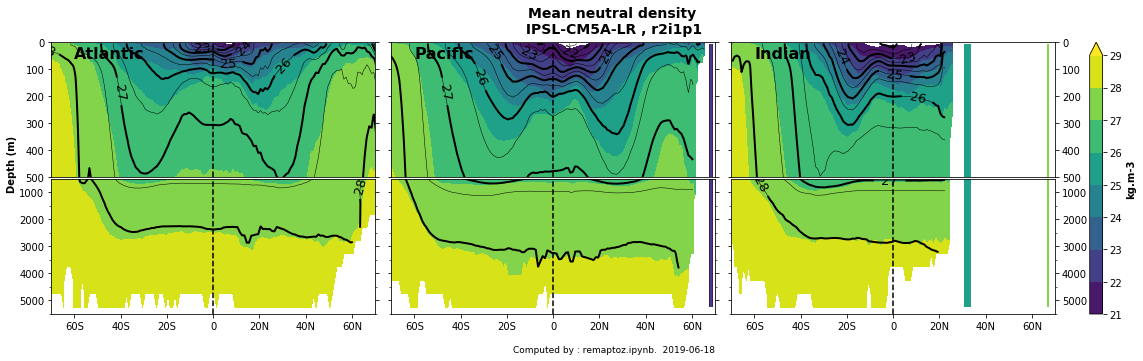

In [22]:
# -- Create figure and axes instances
fig3, axes3 = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

deltat=10
domzed = [0,500,5500]
# -- Color map
cmap1 = 'viridis'
# -- Unit
unit = 'kg.m-3'
# -- Levels
levels = np.arange(21,29.1)
levels2 = levels
ext_cmap = 'max'
# -- Put everything into a dictionary
contourDict = {'cmap':cmap1, 'levels':levels, 'levels2':levels2, 'ext_cmap':ext_cmap, 'isopyc':True}

# -- Contourf
# Atlantic
cnplot3 = zon_2Dz(plt, axes3[0,0], axes3[1,0], 'left', lat, targetz, varAtl,
                  contourDict, domzed, None, None)
# -- Add colorbar
cb1 = fig3.colorbar(cnplot3[0], ax=axes3.ravel().tolist(), ticks=levels, fraction=0.015, shrink=1.0, pad=0.05)
cb1.set_label('%s' % (unit,), fontweight='bold')

# Pacific
cnplot3 = zon_2Dz(plt, axes3[0,1], axes3[1,1], 'mid', lat, targetz, varPac,
                  contourDict, domzed, None, None)

# Indian
cnplot3 = zon_2Dz(plt, axes3[0,2], axes3[1,2], 'right', lat, targetz, varInd,
                  contourDict, domzed, None, None)

plt.subplots_adjust(hspace=.01, wspace=0.05, left=0.04, right=0.86)


# -- Add title
plotTitle = 'Mean neutral density \n %s , %s '%(model_name,run)

plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

plt.figtext(.5,.02,'Computed by : remaptoz.ipynb  '+date,fontsize=9,ha='center')
plt.figtext(.2,.02,'Remapping: '+remap,fontsize=9,ha='center')
plt.figtext(.004,.6,'Depth (m)',rotation='vertical',fontweight='bold')
